In [1]:
import os
import pandas as pd
from snakemake import load_configfile
from lapa.result import LapaResult
import pyranges as pr

os.chdir('..')

In [2]:
config = load_configfile('configs/config.yaml')

In [4]:
gtf = config['long_read']['gm12878']['gtf_pb']
lapa_dir = config['lapa']['long_rna_dir'].format(sample='gm12878')

In [5]:
df_cluster = LapaResult(lapa_dir).read_cluster()

In [6]:
df_cluster['End'] = df_cluster['End'] 

In [7]:
gr_gtf = pr.read_gtf(gtf)

In [8]:
from lapa.utils.io import read_talon_read_annot

df_reads = read_talon_read_annot(config['long_read']['gm12878']['read_annot'])

In [9]:
import numpy as np

df_reads['End'] = np.where(df_reads['Strand'] == '-',
                           df_reads['Start'],
                           df_reads['End'])
df_reads['Start'] = df_reads['End'] - 1
gr_reads = pr.PyRanges(df_reads)

In [10]:
df = gr_reads.nearest(pr.PyRanges(df_cluster), how='downstream', strandedness='same').df
# unclustered = df.Distance > distance
# df.loc[unclustered, 'polyA_site'] = df.loc[unclustered, 'End']
# df.loc[unclustered, 'count'] = 1

# df['polyA_site'] = df['polyA_site'].astype(int)

In [11]:
df_reads = df_reads[df_reads['sample'].str.startswith('PB_GM12878')]

In [12]:
df = df[df['sample'].str.startswith('PB_GM12878')]

In [13]:
_df = df[df.Distance < 1000]

In [23]:
_df_read = df[df.Distance < 1000]

In [18]:
df_reads[~df_reads['read_name'].isin(set(_df['read_name']))]

,read_name,sample,genome_build,Chromosome,Start,End,Strand,n_exons,read_length,gene_ID,...,annot_gene_name,annot_transcript_name,gene_novelty,transcript_novelty,ISM_subtype,fraction_As,custom_label,allelic_label,start_support,end_support
5,m54284U_191110_105540/63769017/ccs,PB_GM12878_R1,hg38_SIRV,ERCC-00071,623,624,+,1,623,58762,...,None,None,Known,Known,None,0.00,None,None,None,None
8,m54284U_191111_172039/43254820/ccs,PB_GM12878_R2,hg38_SIRV,ERCC-00071,624,625,+,1,624,58762,...,None,None,Known,Known,None,0.00,None,None,None,None
10,m54284U_191111_172039/132450820/ccs,PB_GM12878_R2,hg38_SIRV,ERCC-00071,623,624,+,1,623,58762,...,None,None,Known,Known,None,0.00,None,None,None,None
15,m54284U_191111_172039/71960772/ccs,PB_GM12878_R2,hg38_SIRV,ERCC-00033,580,581,+,1,578,58740,...,None,None,Known,Known,None,0.60,None,None,None,None
22,m54284U_191110_105540/919473/ccs,PB_GM12878_R1,hg38_SIRV,ERCC-00144,519,520,+,1,518,58801,...,None,None,Known,Known,None,0.00,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7324481,m54284U_191111_172039/50464476/ccs,PB_GM12878_R2,hg38_SIRV,chr12,133192125,133192126,-,1,522,134236,...,ENCODEHG000134236,ENCODEHT000697048,Antisense,Antisense,None,0.90,None,None,None,None
7324495,m54284U_191111_172039/121766902/ccs,PB_GM12878_R2,hg38_SIRV,chr12,133206058,133206059,+,1,2108,36736,...,ZNF268,ENCODEHT000697049,Known,Genomic,None,0.20,None,None,None,None
7324499,m54284U_191110_105540/20514950/ccs,PB_GM12878_R1,hg38_SIRV,chr12,133204799,133204800,-,1,1861,134237,...,ENCODEHG000134237,ENCODEHT000697050,Antisense,Antisense,None,0.50,None,None,None,None
7324504,m54284U_191110_105540/75301488/ccs,PB_GM12878_R1,hg38_SIRV,chr12,133205958,133205959,+,1,1029,36736,...,ZNF268,ENCODEHT000697049,Known,Genomic,None,0.25,None,None,None,None


In [20]:
df_reads.shape

(4452205, 23)

In [21]:
_df = _df.groupby(['transcript_ID', 'polyA_site']).agg({'count': 'count'})

In [24]:
_df

count
transcript_ID polyA_site        
32            184920.0         1
93            632672.0         1
136           841999.0         4
              844566.0         6
175           944215.0       134
...                          ...
697043        133204704.0      1
697044        133205123.0      1
697045        133202439.0      1
697046        133205123.0      1
697049        133205123.0     12

[243298 rows x 1 columns]

In [25]:
_df = _df[_df['count'] > 25]

In [26]:
_df = _df.reset_index().groupby('transcript_ID').agg({'count': 'count'}) 

In [27]:
_df[_df['count'] > 1].sum()

count    4643
dtype: int64

In [28]:
_df.shape[0] - _df[_df['count'] > 1].sum()

count    4795
dtype: int64

In [29]:
_df[_df['count'] > 1]

,count
transcript_ID,
437,2
719,3
1033,4
1167,3
1446,2
...,...
686857,2
686860,2
686867,2


In [65]:
from collections import Counter

t_c = pd.Series(Counter(df_reads[~df_reads['read_name'].isin(_df_read['read_name'])]['transcript_ID']))

In [98]:
t_c[t_c > 15]

208765    16
209903    21
210060    34
210062    19
210909    23
          ..
693994    46
695686    18
695696    18
104482    47
696284    30
Length: 689, dtype: int64

In [110]:
transcript_id = 696284

In [111]:
count_tes = df[df['transcript_ID'] == transcript_id].groupby('polyA_site').agg({'count': 'count'}).sort_index()
count_tes

,count
polyA_site,
133362781.0,30


In [112]:
# count_tes = count_tes[count_tes > 25]

In [113]:
clustured = set(_df_read[_df_read['transcript_ID'] == transcript_id]['read_name'])
_df_t = df_reads[df_reads['transcript_ID'] == transcript_id]

# count_reads = _df_t.groupby('End').agg({'read_name': 'count'}).sort_index()
count_reads_clustered = _df_t[_df_t['read_name'].isin(clustured)].groupby('End').agg({'read_name': 'count'}).sort_index()
count_reads_unclustered = _df_t[~_df_t['read_name'].isin(clustured)].groupby('End').agg({'read_name': 'count'}).sort_index()

Text(0, 0.5, 'Number of reads')

<Figure size 432x288 with 0 Axes>

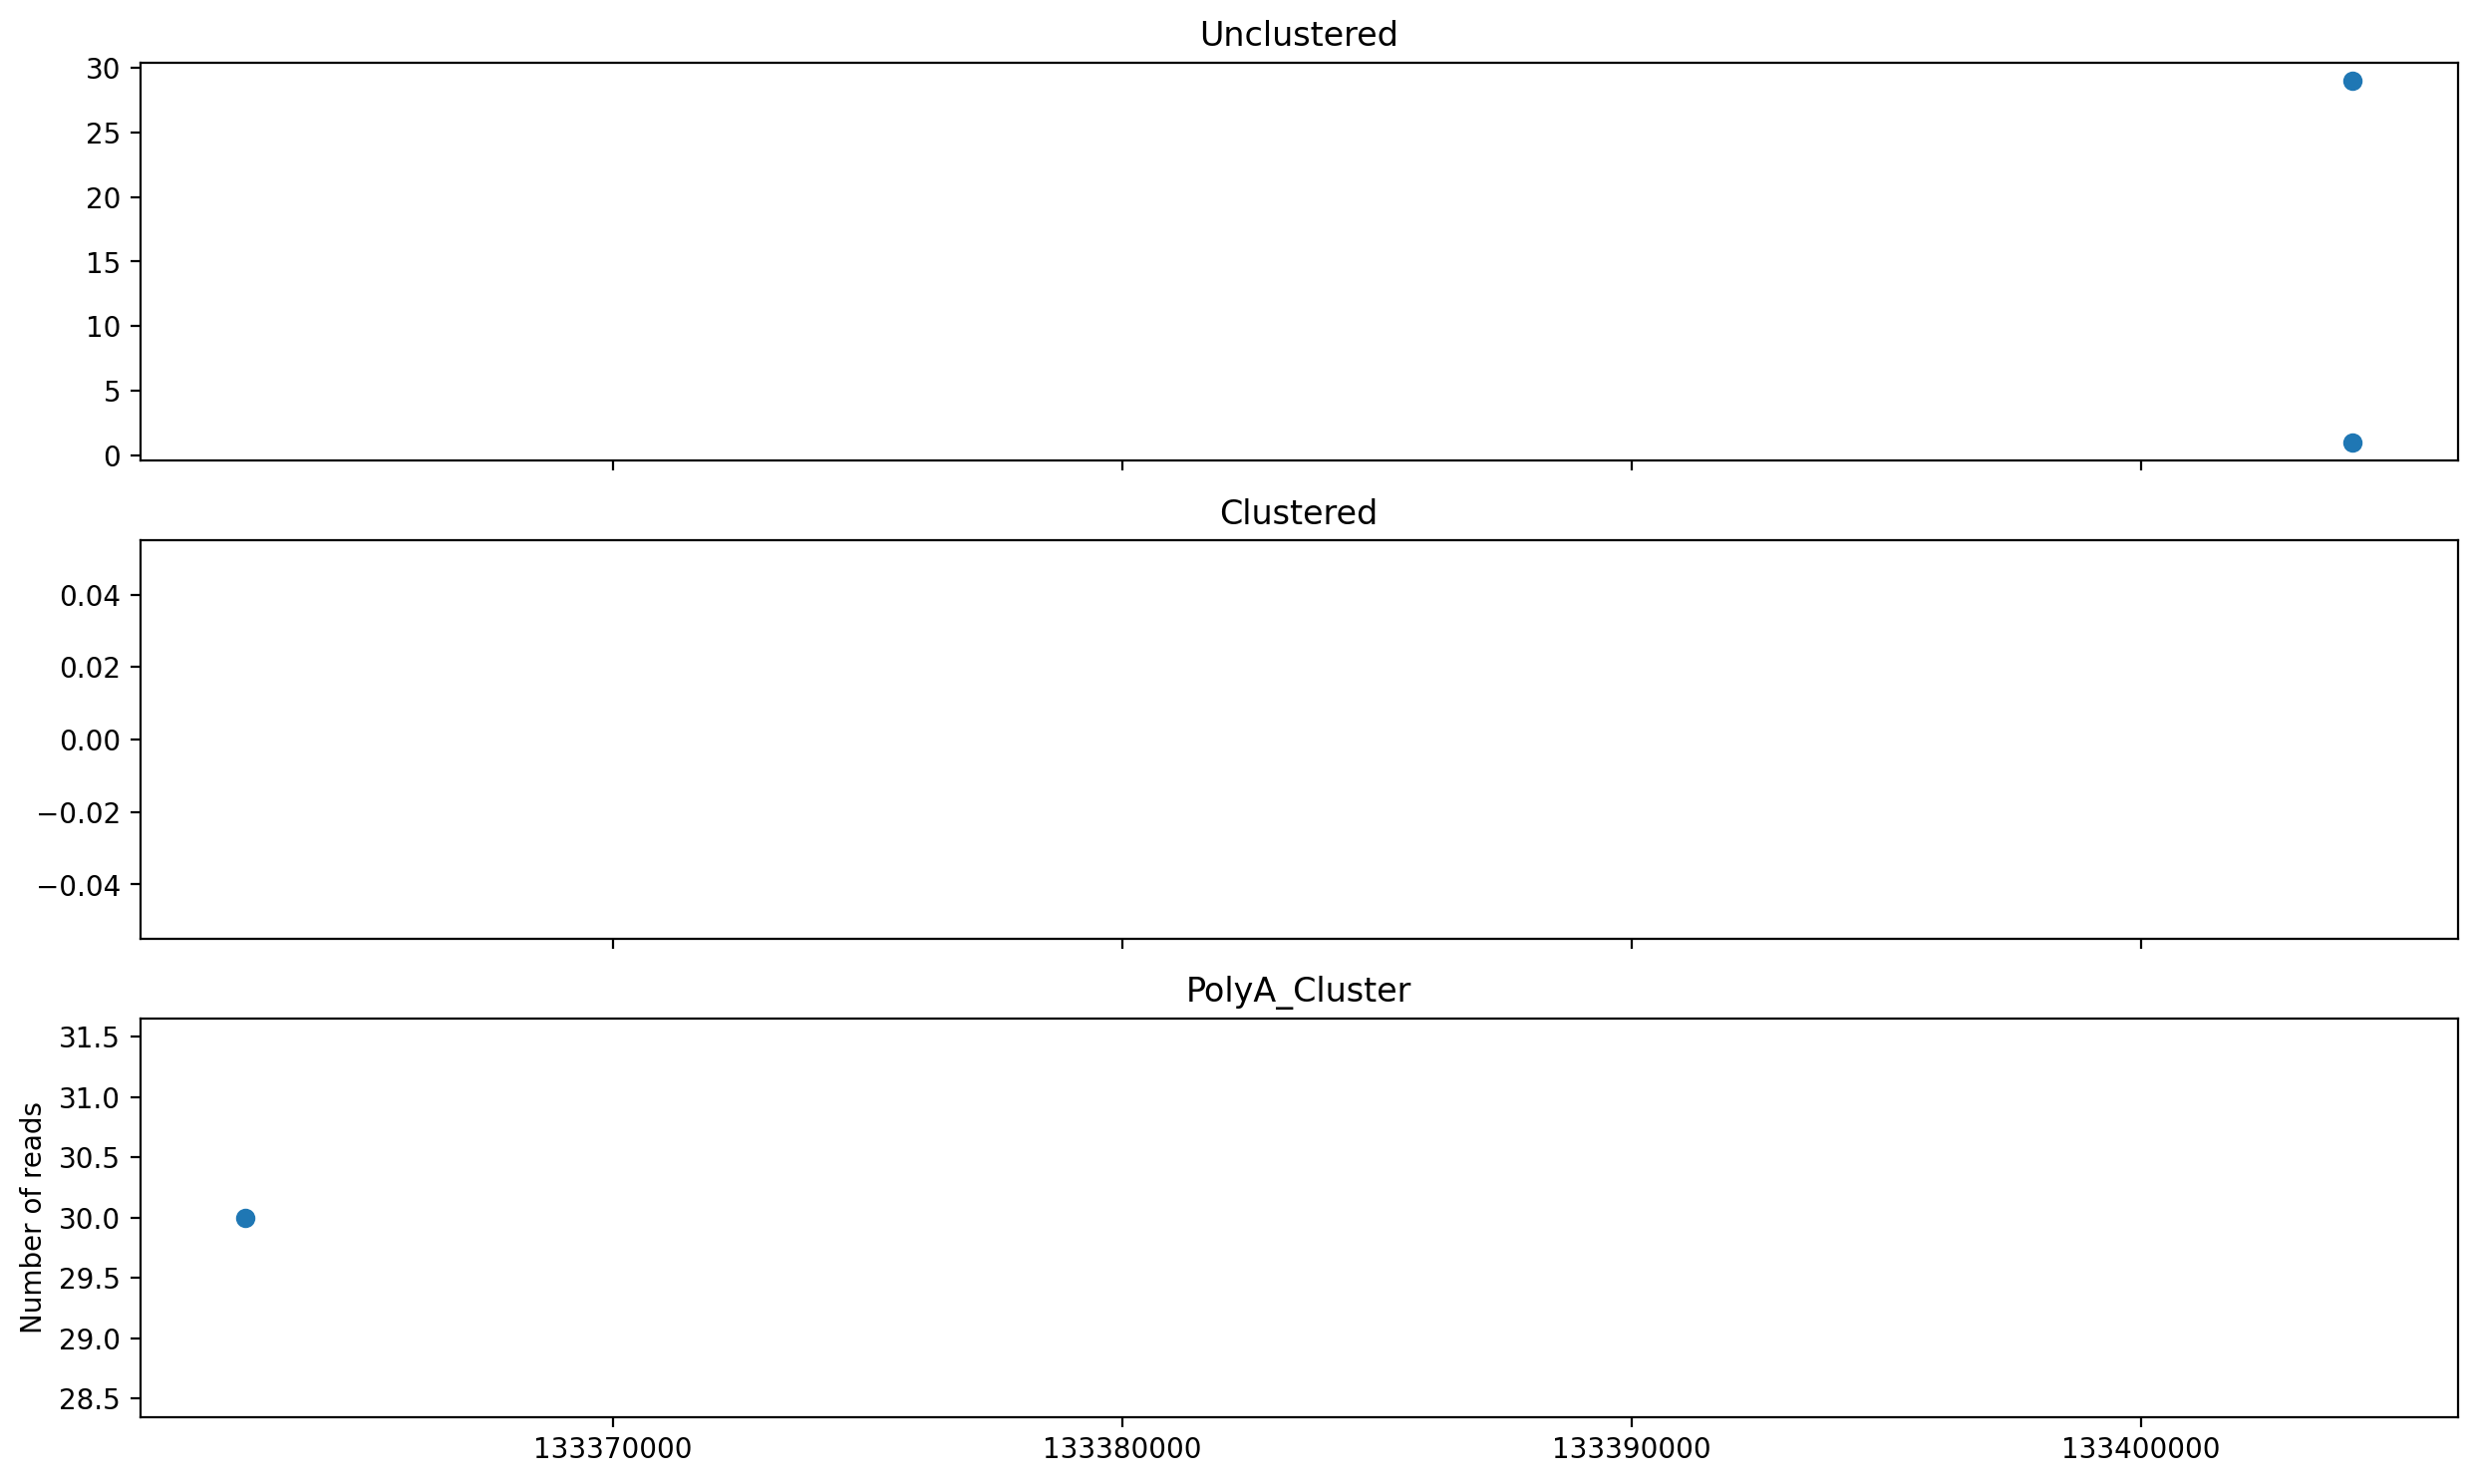

In [114]:
import matplotlib.pyplot as plt

plt.figure()
fig, ((ax1, ax2, ax3)) = plt.subplots(3, 1, figsize=(15, 9), dpi=200, sharex=True)

ax1.scatter(count_reads_unclustered.index, count_reads_unclustered)
ax1.set_title('Unclustered')
ax1.ticklabel_format(style='plain')

ax2.scatter(count_reads_clustered.index, count_reads_clustered)
ax2.set_title('Clustered')
ax2.ticklabel_format(style='plain')

ax3.scatter(count_tes.index, count_tes)
ax3.set_title('PolyA_Cluster')
ax3.ticklabel_format(style='plain')

plt.grid(False)
plt.ylabel('Number of reads')


In [104]:
df[df['transcript_ID'] == 1033]

,read_name,sample,genome_build,Chromosome,Start,End,Strand,n_exons,read_length,gene_ID,...,End_b,polyA_site,tpm,Strand_b,Feature,count,fracA,signal,canonical_site,Distance
363067,m54284U_191110_105540/75891983/ccs,PB_GM12878_R1,hg38_SIRV,chr1,6185019,6185020,-,4,2059,230,...,6185127.0,6185032.0,61.898285,-,three_prime_utr,399.0,2.0,6185057@ATTAAA,6185019.0,0
363072,m54284U_191110_105540/89850608/ccs,PB_GM12878_R1,hg38_SIRV,chr1,6185020,6185021,-,4,2060,230,...,6185127.0,6185032.0,61.898285,-,three_prime_utr,399.0,2.0,6185057@ATTAAA,6185019.0,0
363073,m54284U_191110_105540/112461258/ccs,PB_GM12878_R1,hg38_SIRV,chr1,6185020,6185021,-,4,2059,230,...,6185127.0,6185032.0,61.898285,-,three_prime_utr,399.0,2.0,6185057@ATTAAA,6185019.0,0
363075,m54284U_191110_105540/118948171/ccs,PB_GM12878_R1,hg38_SIRV,chr1,6185020,6185021,-,4,2058,230,...,6185127.0,6185032.0,61.898285,-,three_prime_utr,399.0,2.0,6185057@ATTAAA,6185019.0,0
363076,m54284U_191110_105540/175964459/ccs,PB_GM12878_R1,hg38_SIRV,chr1,6185020,6185021,-,4,2061,230,...,6185127.0,6185032.0,61.898285,-,three_prime_utr,399.0,2.0,6185057@ATTAAA,6185019.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
652949,m54284U_191110_105540/135465133/ccs,PB_GM12878_R1,hg38_SIRV,chr1,6186172,6186173,-,4,907,230,...,6186096.0,6186083.0,25.907302,-,three_prime_utr,167.0,4.0,6186111@CATAAA,6185019.0,77
652953,m54284U_191111_172039/155780197/ccs,PB_GM12878_R2,hg38_SIRV,chr1,6186268,6186269,-,4,812,230,...,6186264.0,6186220.0,104.715145,-,three_prime_utr,675.0,1.0,6186253@AATAAA,6185019.0,5
652954,m54284U_191111_172039/74449919/ccs,PB_GM12878_R2,hg38_SIRV,chr1,6186271,6186272,-,4,806,230,...,6186264.0,6186220.0,104.715145,-,three_prime_utr,675.0,1.0,6186253@AATAAA,6185019.0,8
652960,m54284U_191111_172039/121635368/ccs,PB_GM12878_R2,hg38_SIRV,chr1,6186367,6186368,-,4,714,230,...,6186264.0,6186220.0,104.715145,-,three_prime_utr,675.0,1.0,6186253@AATAAA,6185019.0,104


In [45]:
lapa_dir

'data/results/lapa/gm12878/long_rna_lapa'

In [ ]:
# TODO: look at this example on igv